In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**3,1)
tt = .8*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=32))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(10,10))
plt.title("3-step MDP - W-state preparation", size=50)
plt.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
plt.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
plt.legend(prop={"size":20})

100%|██████████| 999/999 [00:46<00:00, 21.27it/s]


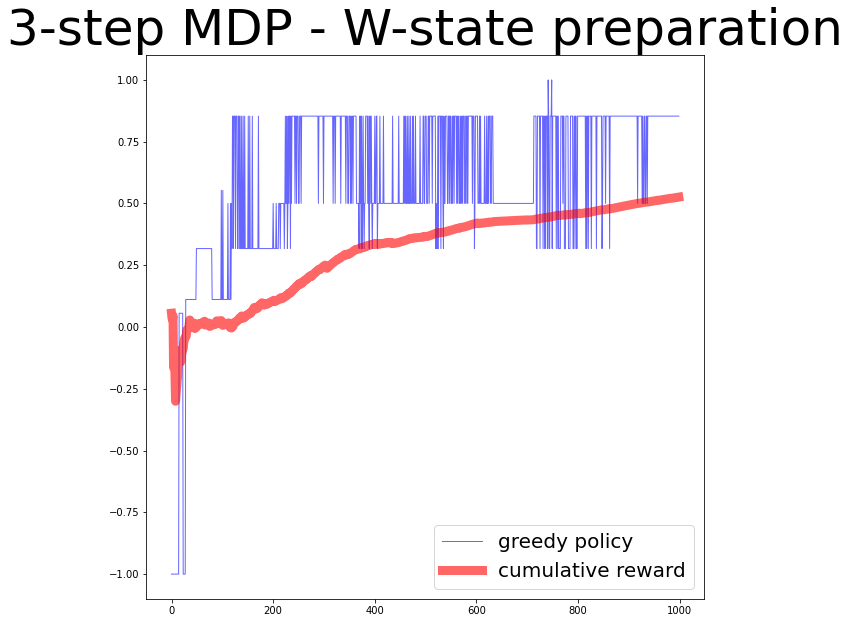

100%|██████████| 999/999 [00:48<00:00, 20.81it/s]


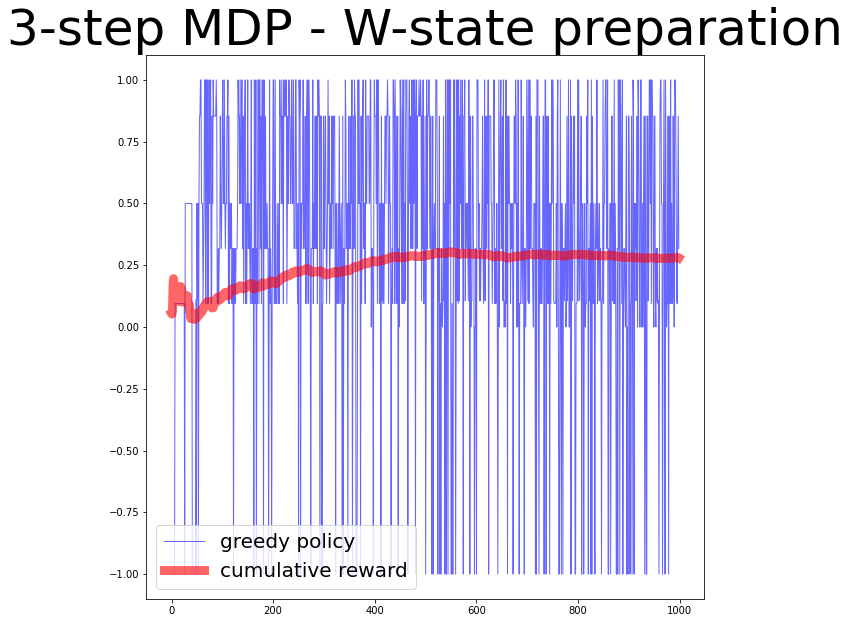

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.05)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**3,1)
tt = .8*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=32))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(10,10))
plt.title("3-step MDP - W-state preparation", size=50)
plt.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
plt.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
plt.legend(prop={"size":20})

100%|██████████| 1999/1999 [01:37<00:00, 20.60it/s]


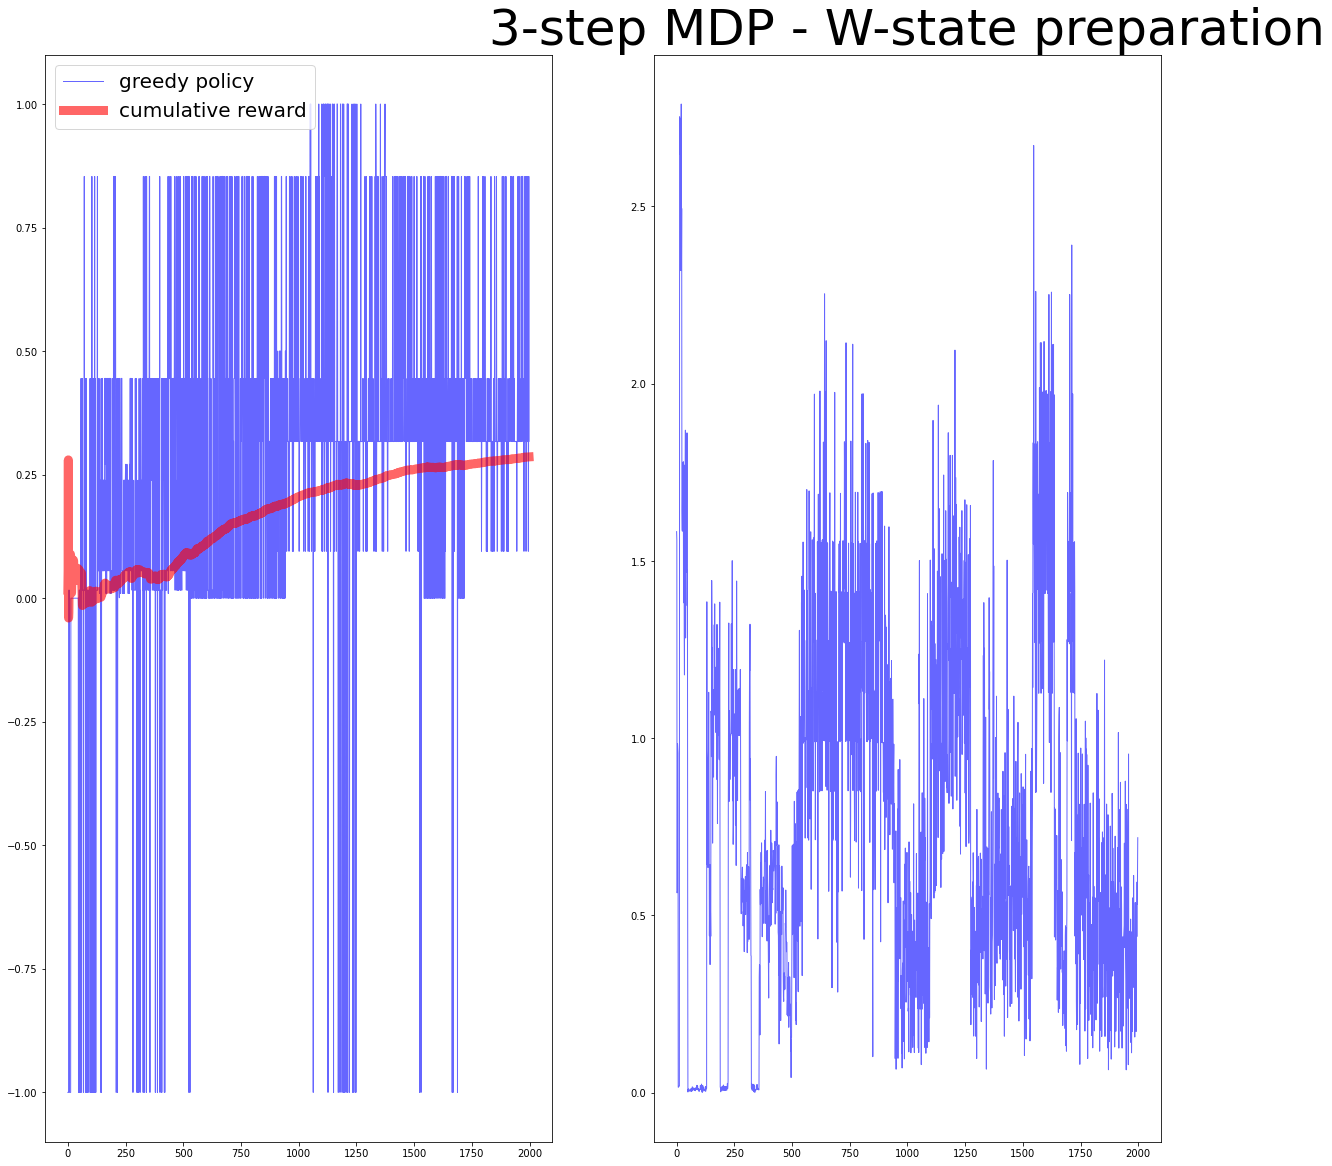

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.005)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=32))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [02:09<00:00, 15.46it/s]


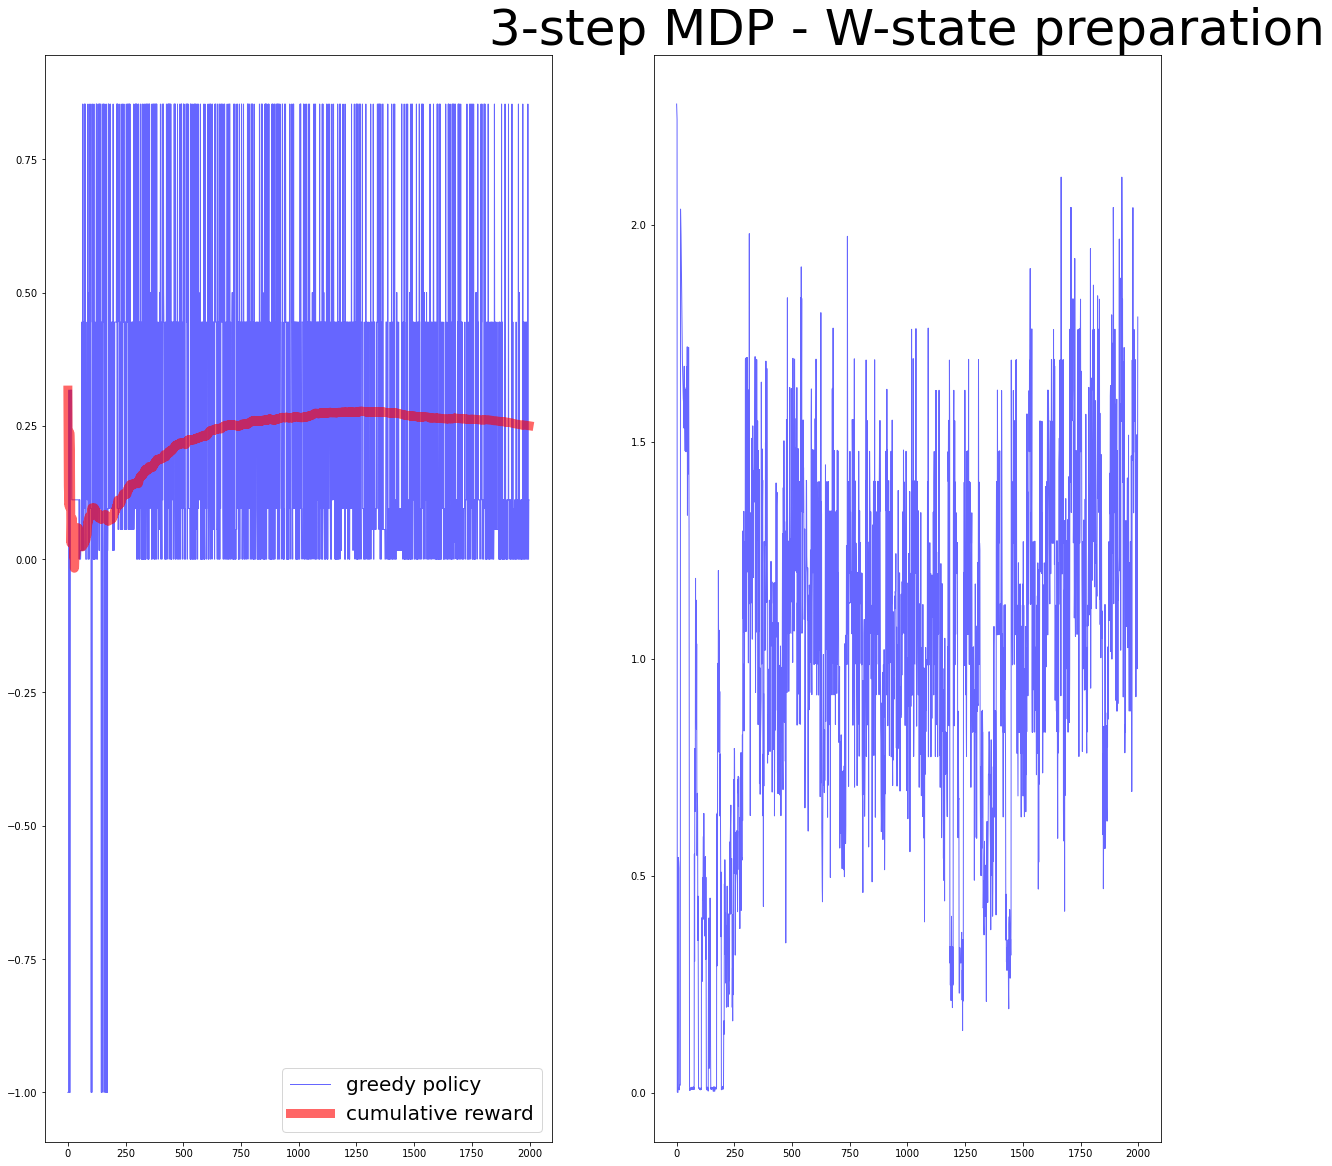

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.005)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=64))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [02:05<00:00, 15.97it/s]


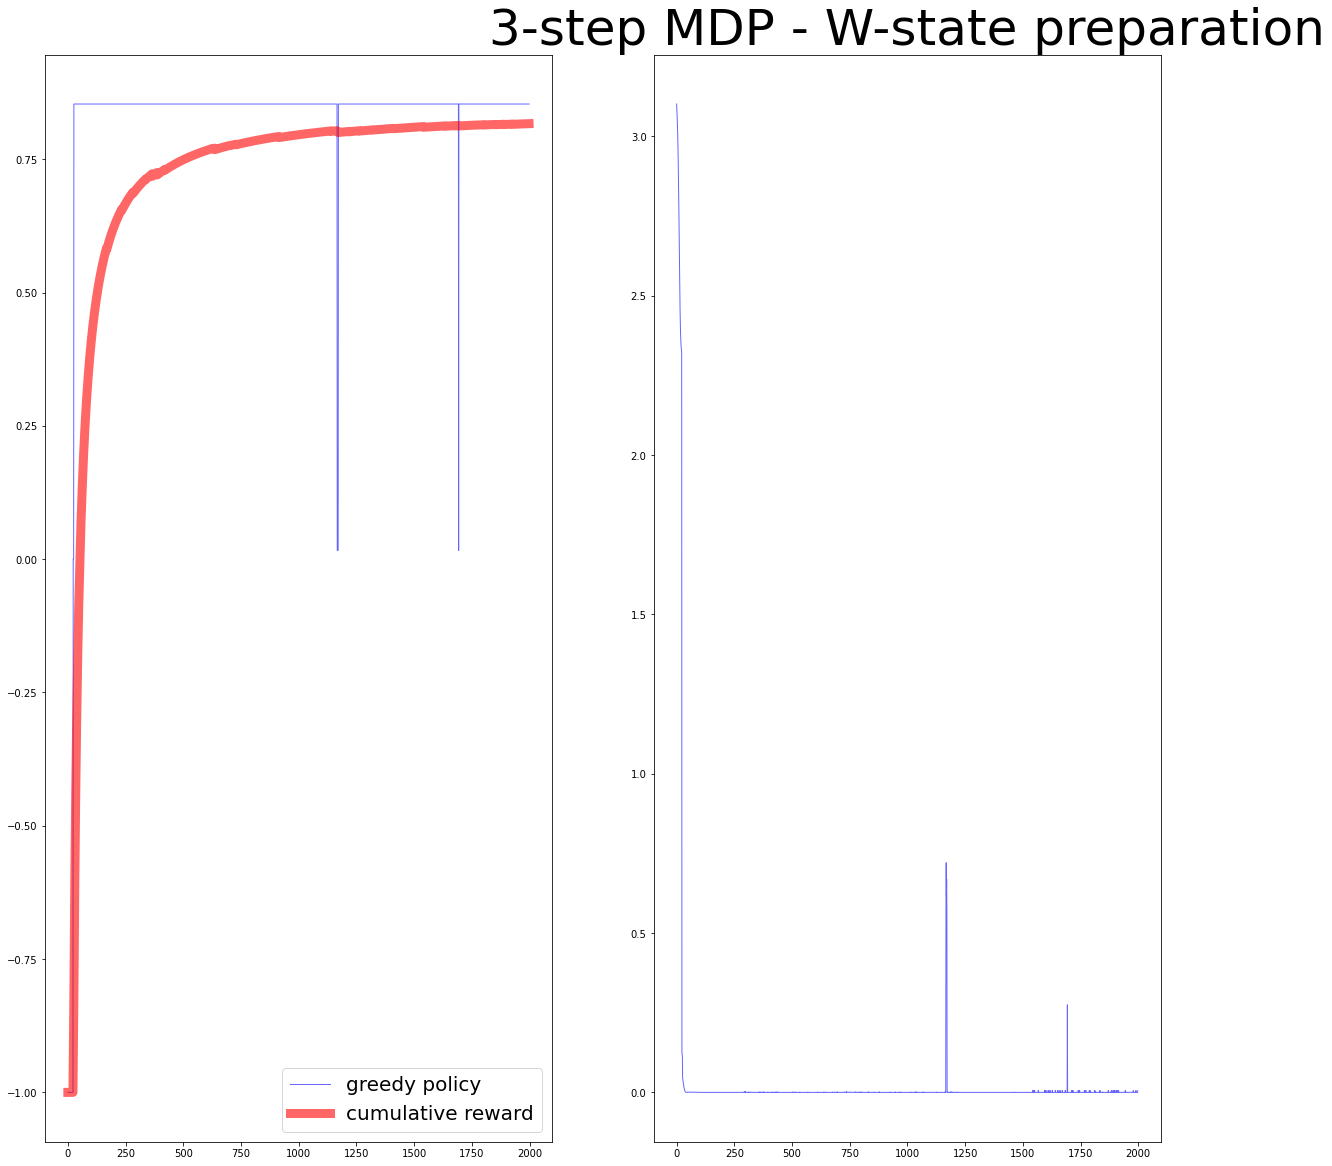

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.005)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return 0.01
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=64))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

In [15]:
pt[-1]

0.8534780916746114

100%|██████████| 1999/1999 [02:04<00:00, 16.00it/s]


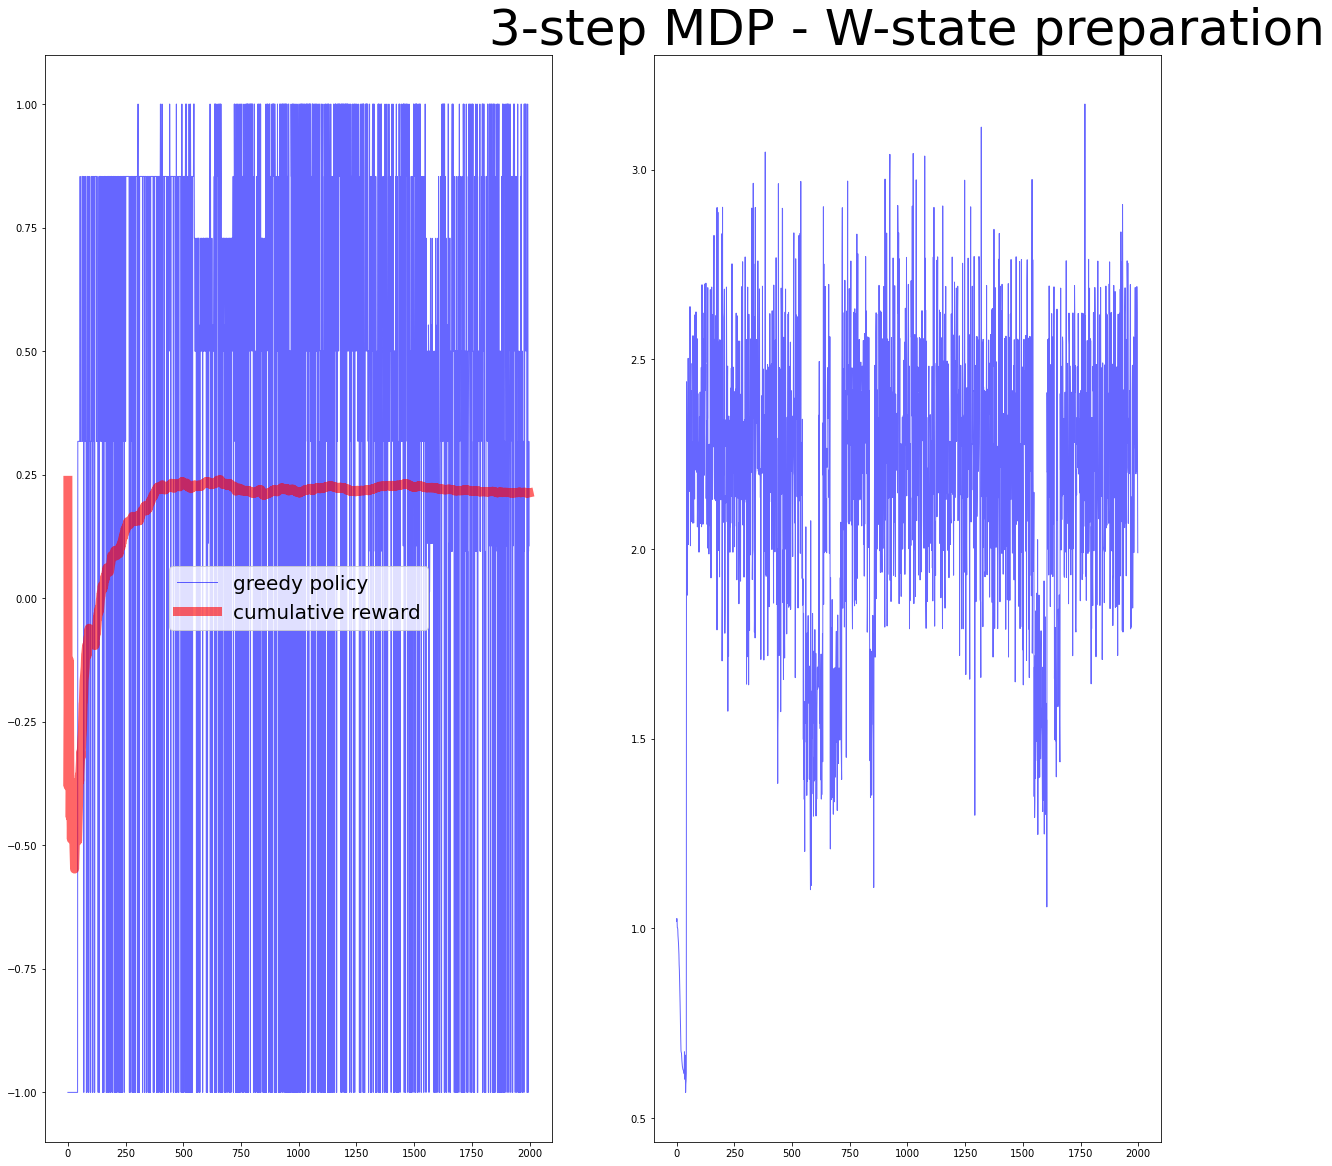

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.005)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return 0.3
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=64))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [02:56<00:00, 11.34it/s]


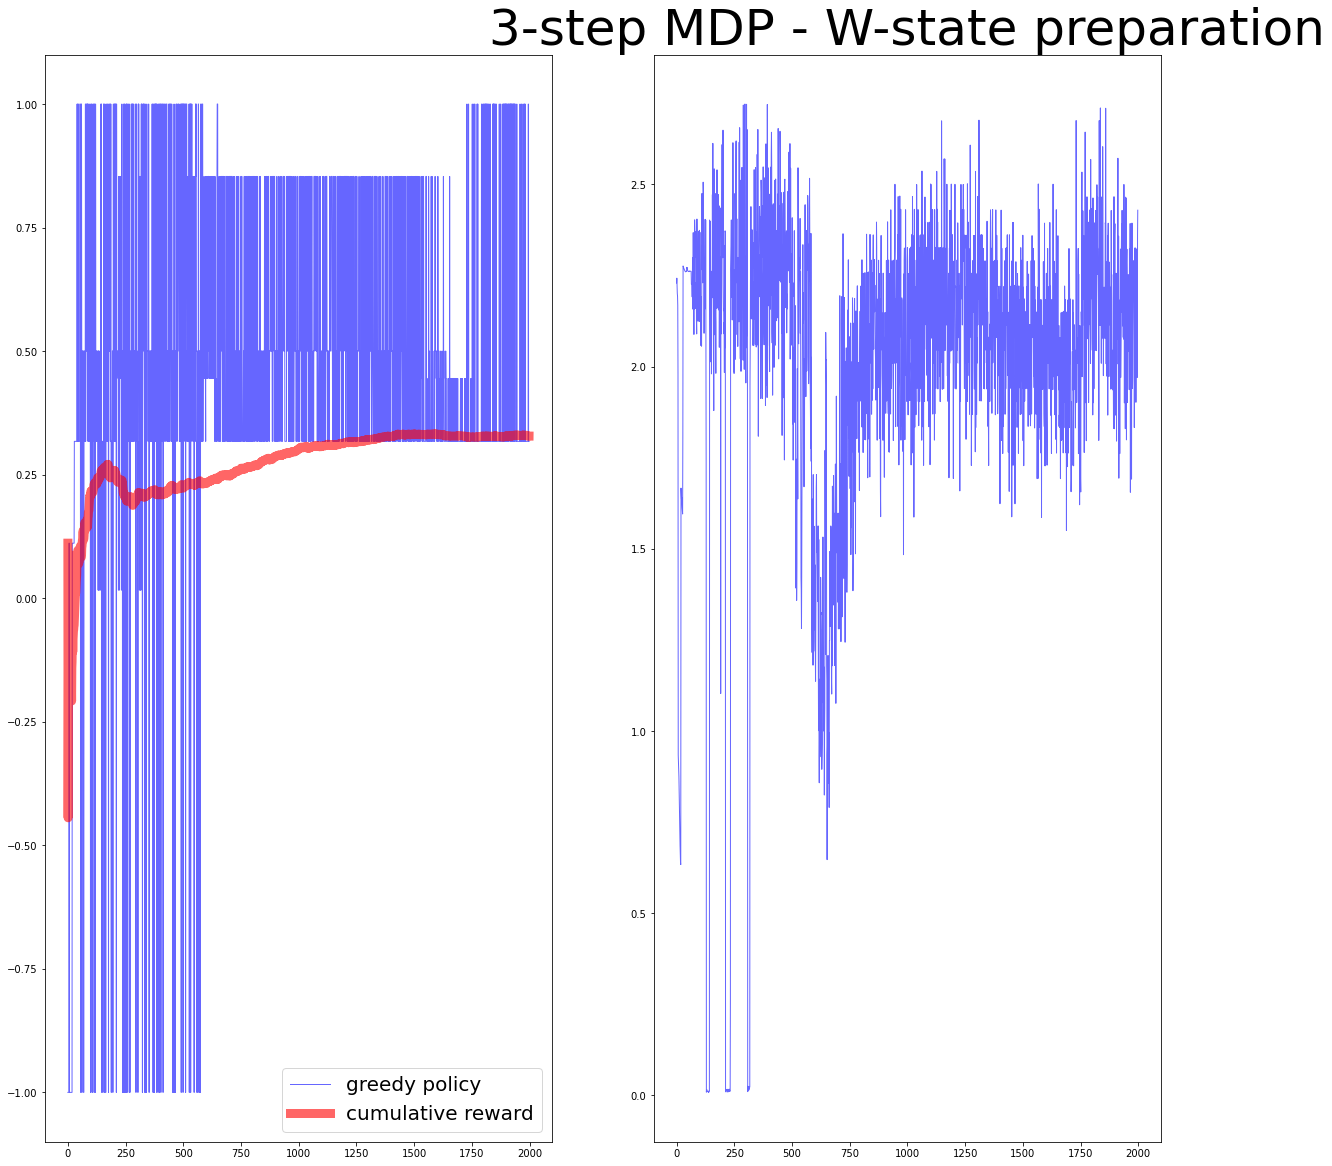

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return 0.3
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=128))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [01:16<00:00, 26.14it/s]


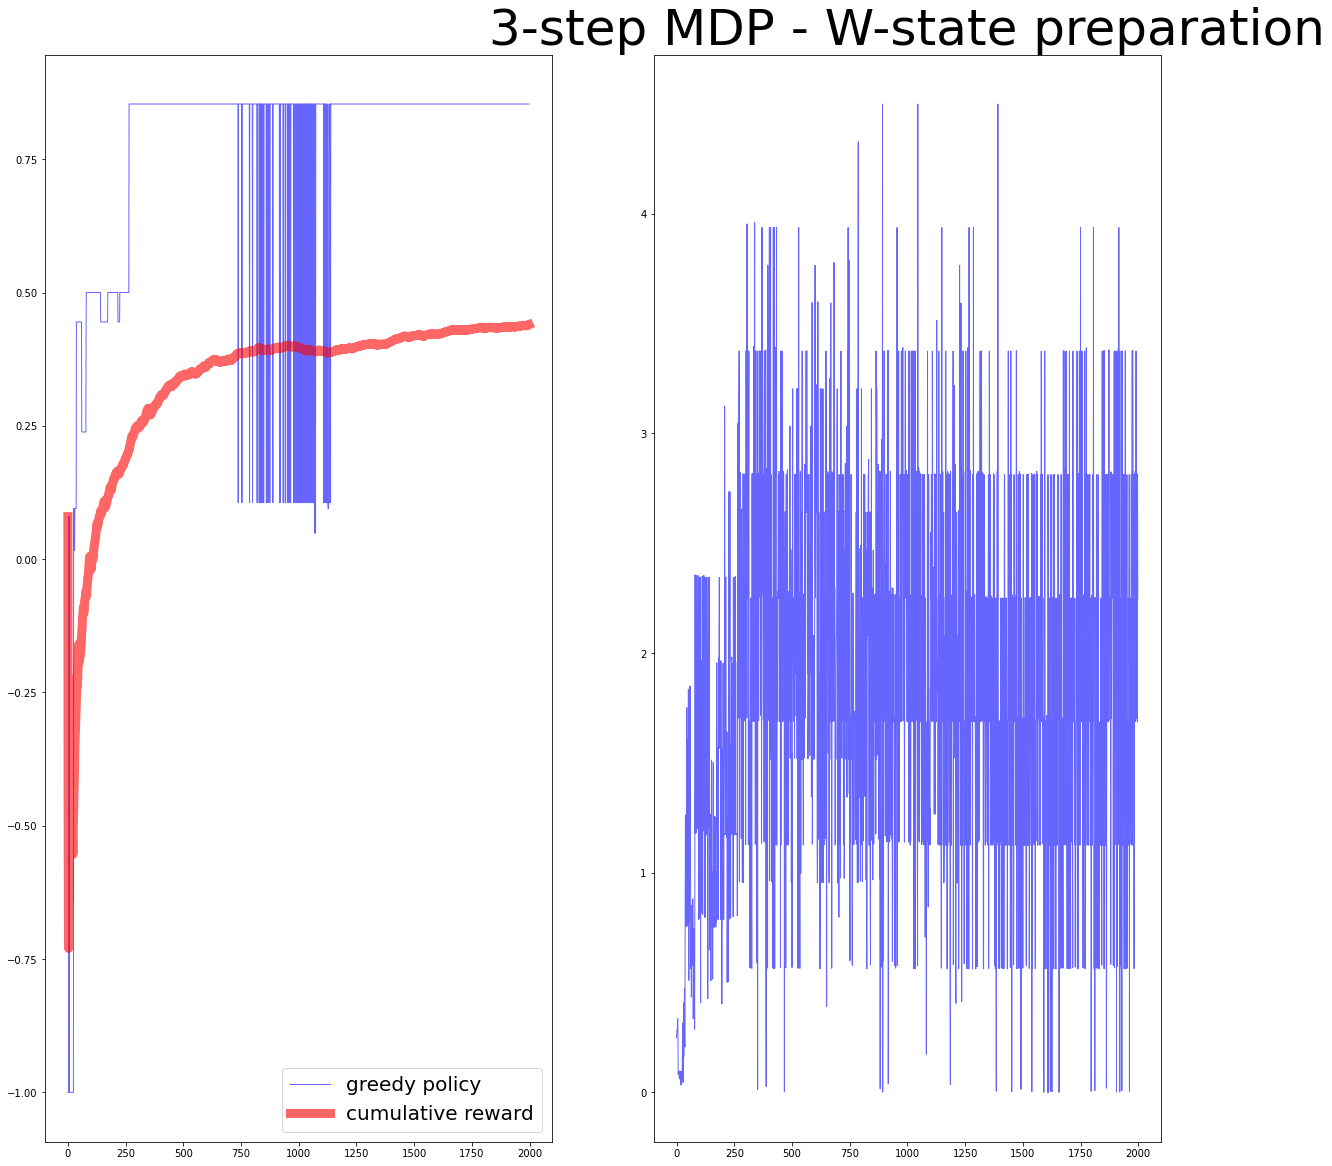

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return 0.3
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=8))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [01:06<00:00, 30.05it/s]


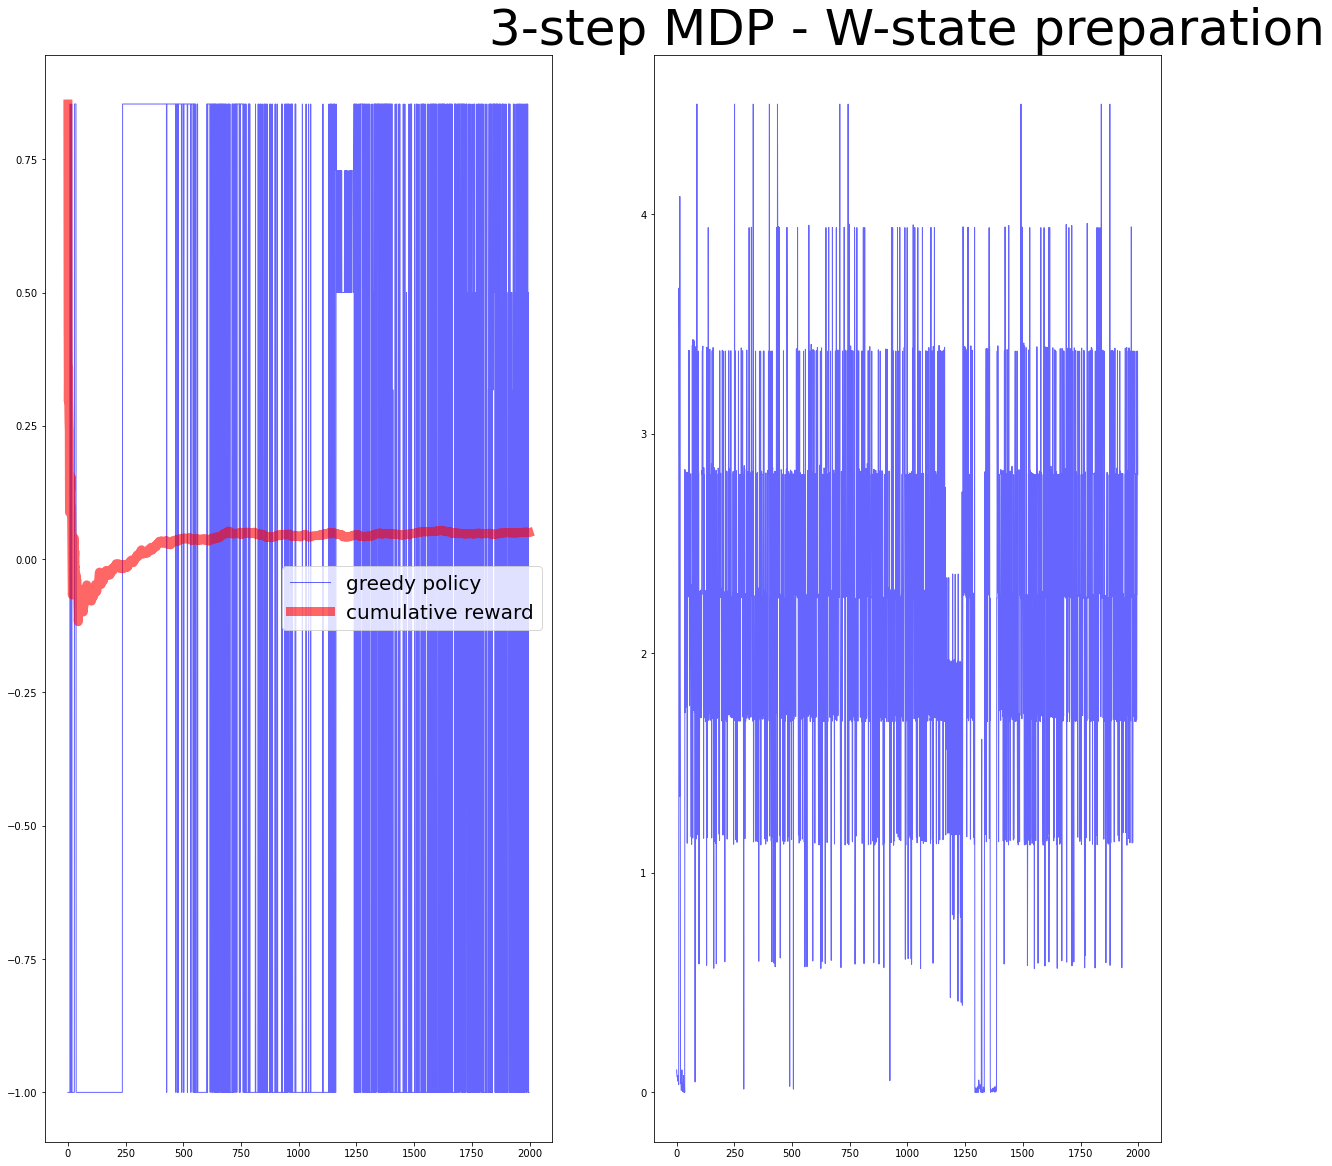

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return 1
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=8))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [01:14<00:00, 26.97it/s]


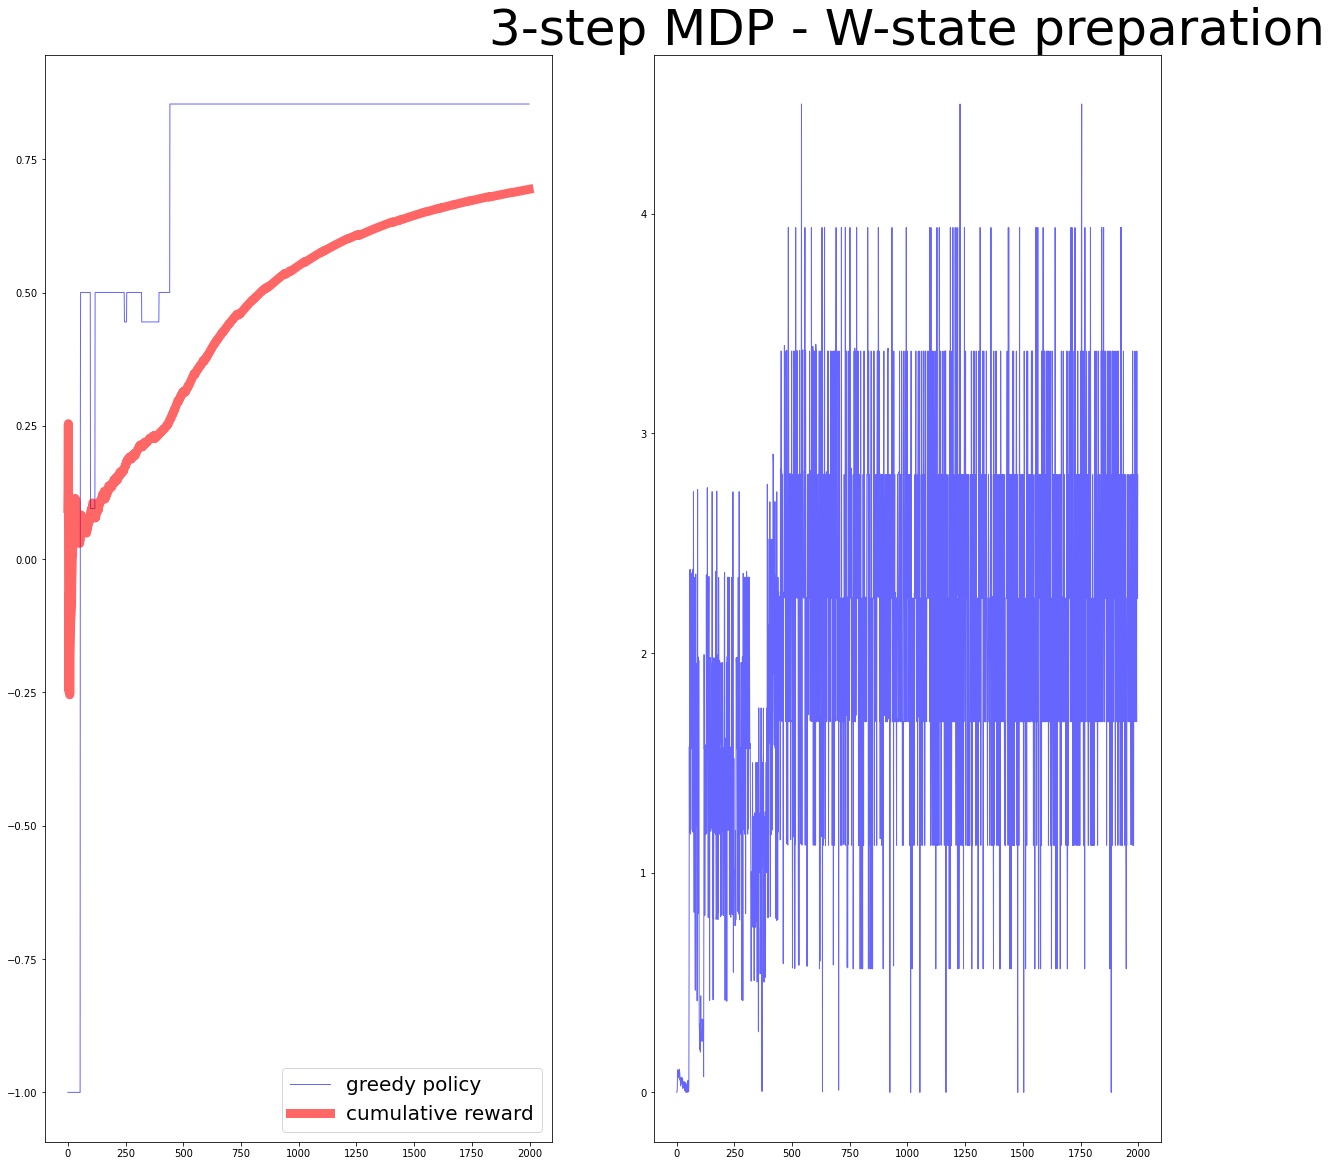

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=8))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [04:59<00:00,  6.68it/s]


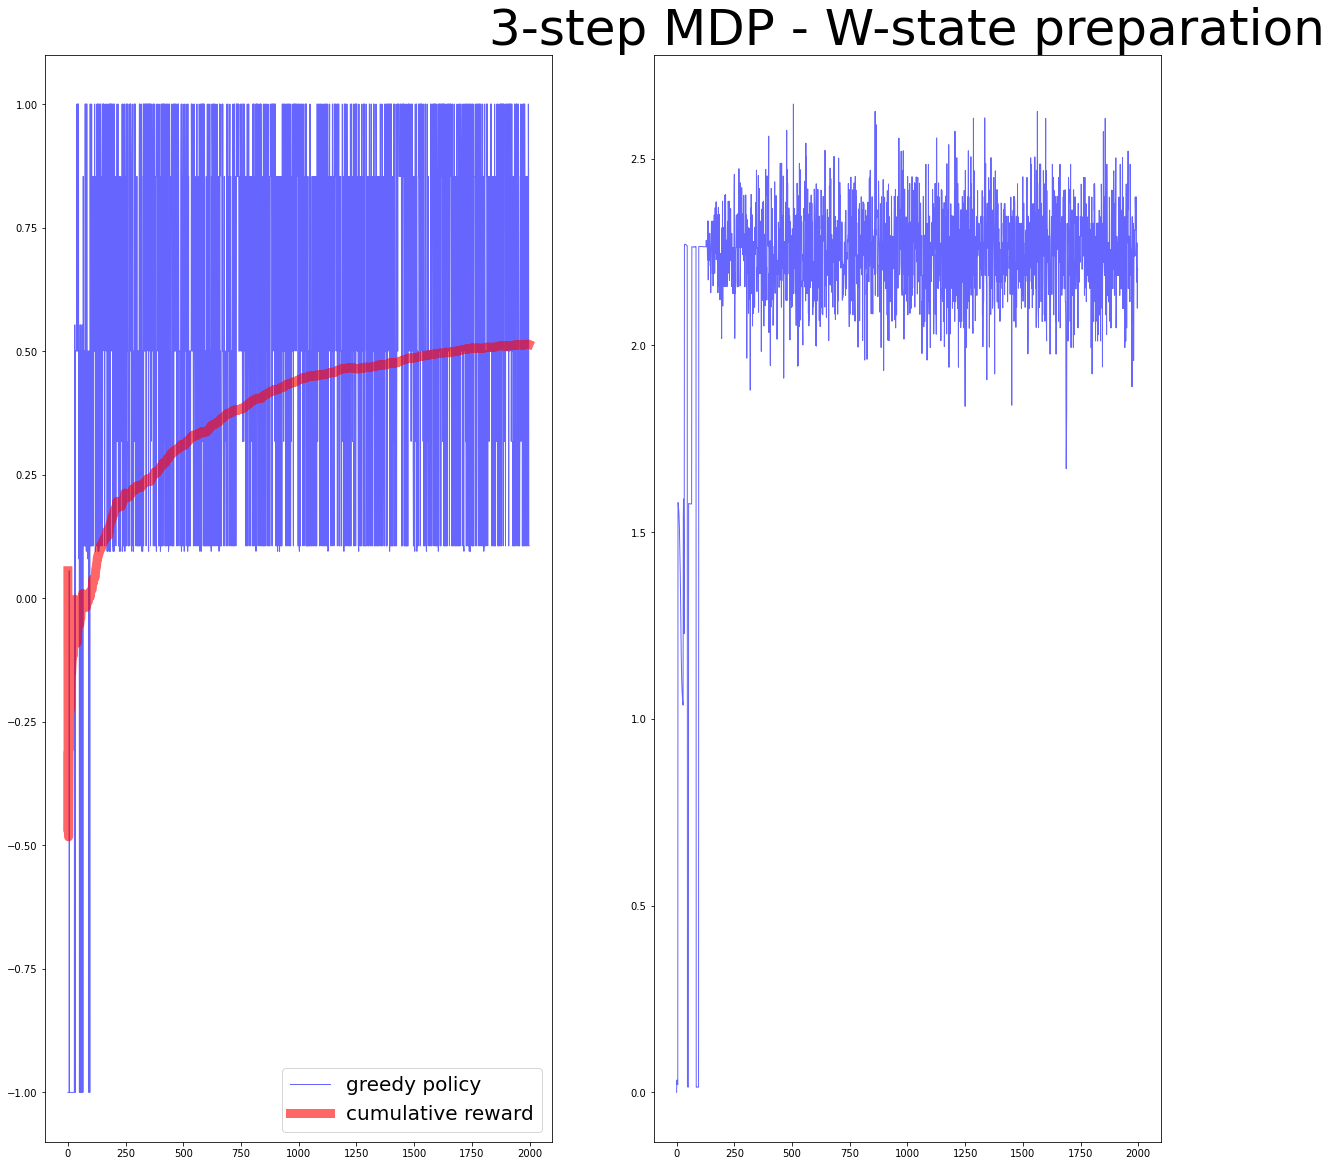

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=256))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [04:45<00:00,  7.00it/s]


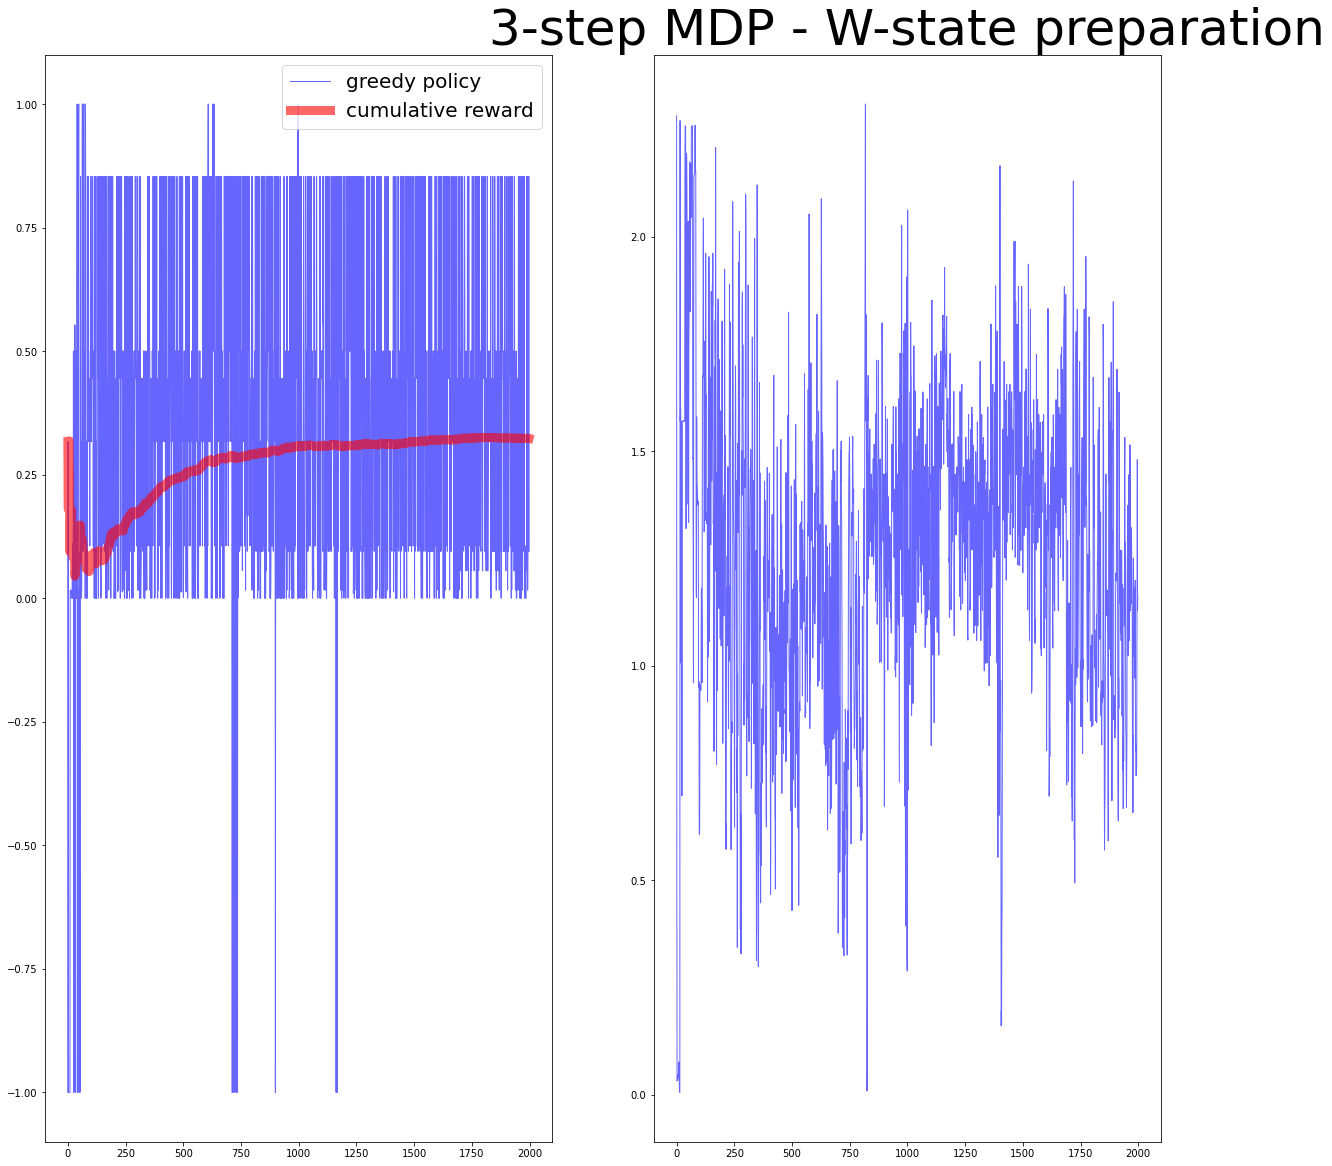

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.05)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.1)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=256))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 1999/1999 [04:45<00:00,  7.01it/s]


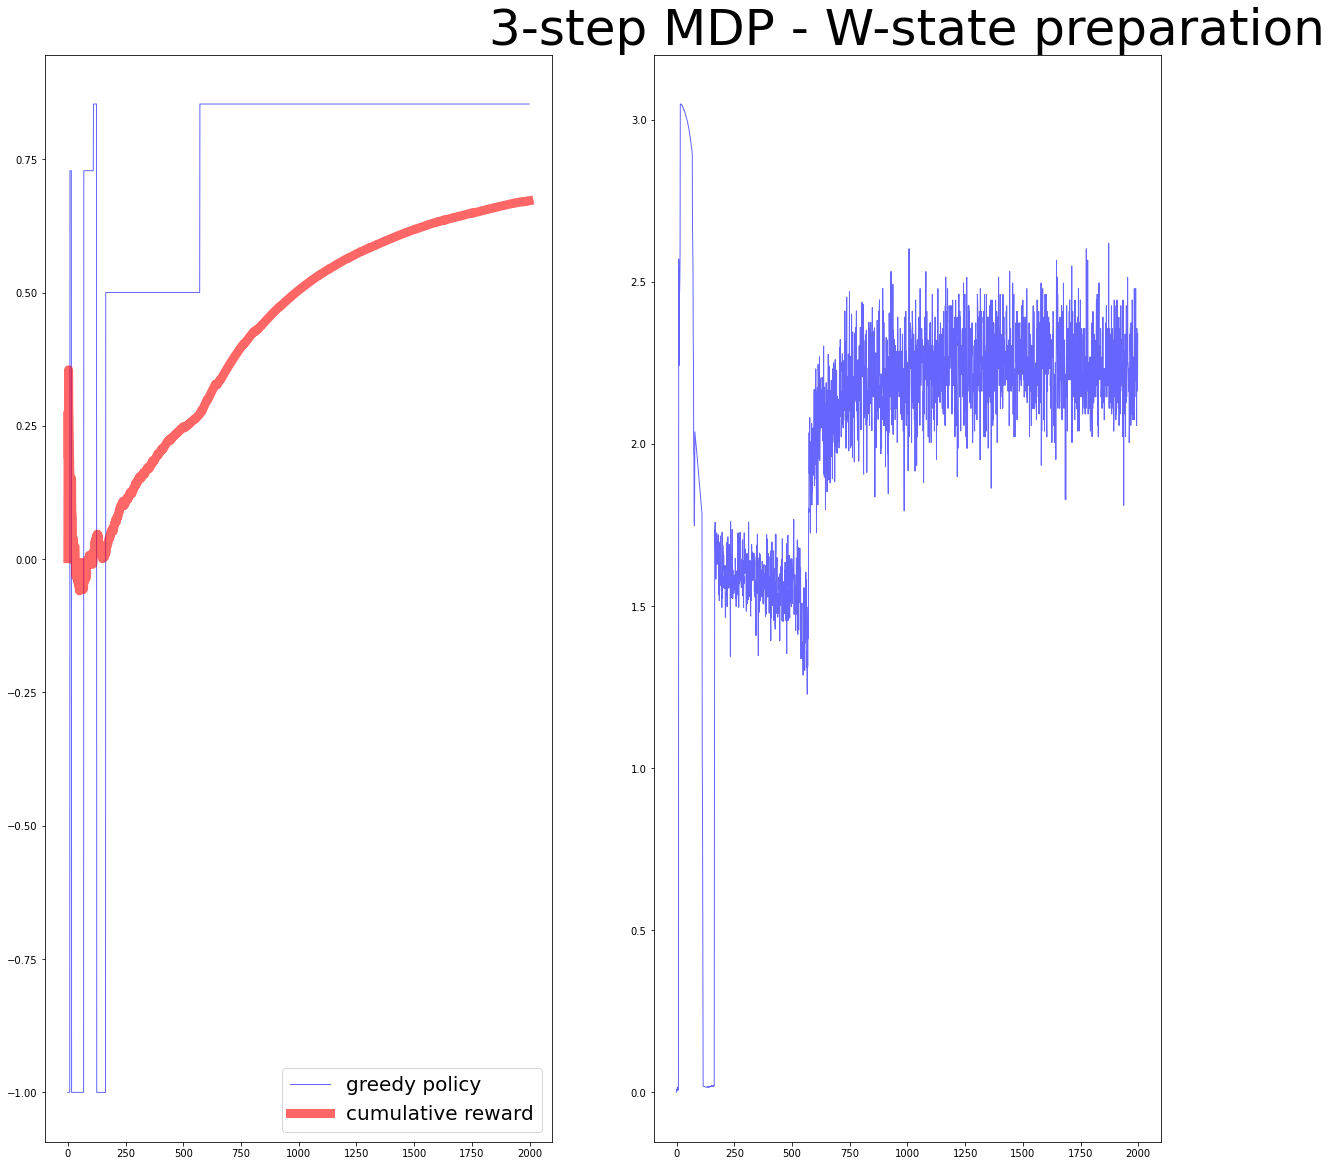

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=3, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.5)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.001)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,2*10**3,1)
tt = .5*len(episodes)/np.log(1/0.01)
def schedule(k):
    return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state


    lhist.append(learning_step(critic, buffer, optimizer, batch_size=256))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**3,1)
tt = .8*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=32))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 999/999 [00:49<00:00, 20.05it/s]


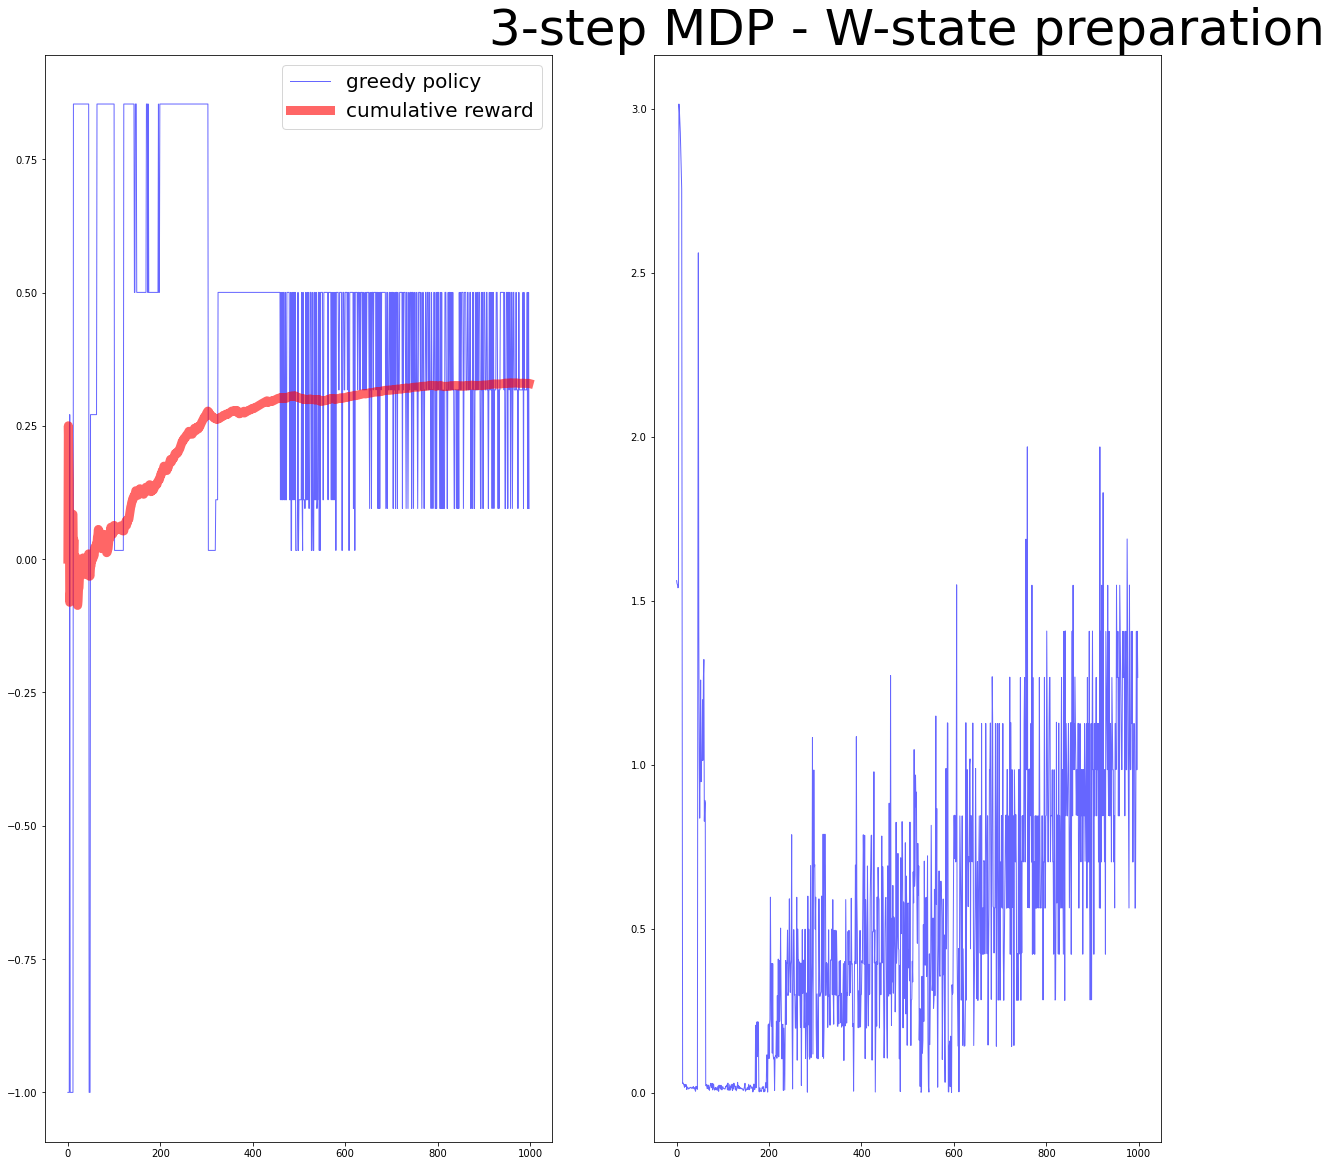

100%|██████████| 999/999 [00:48<00:00, 20.44it/s]


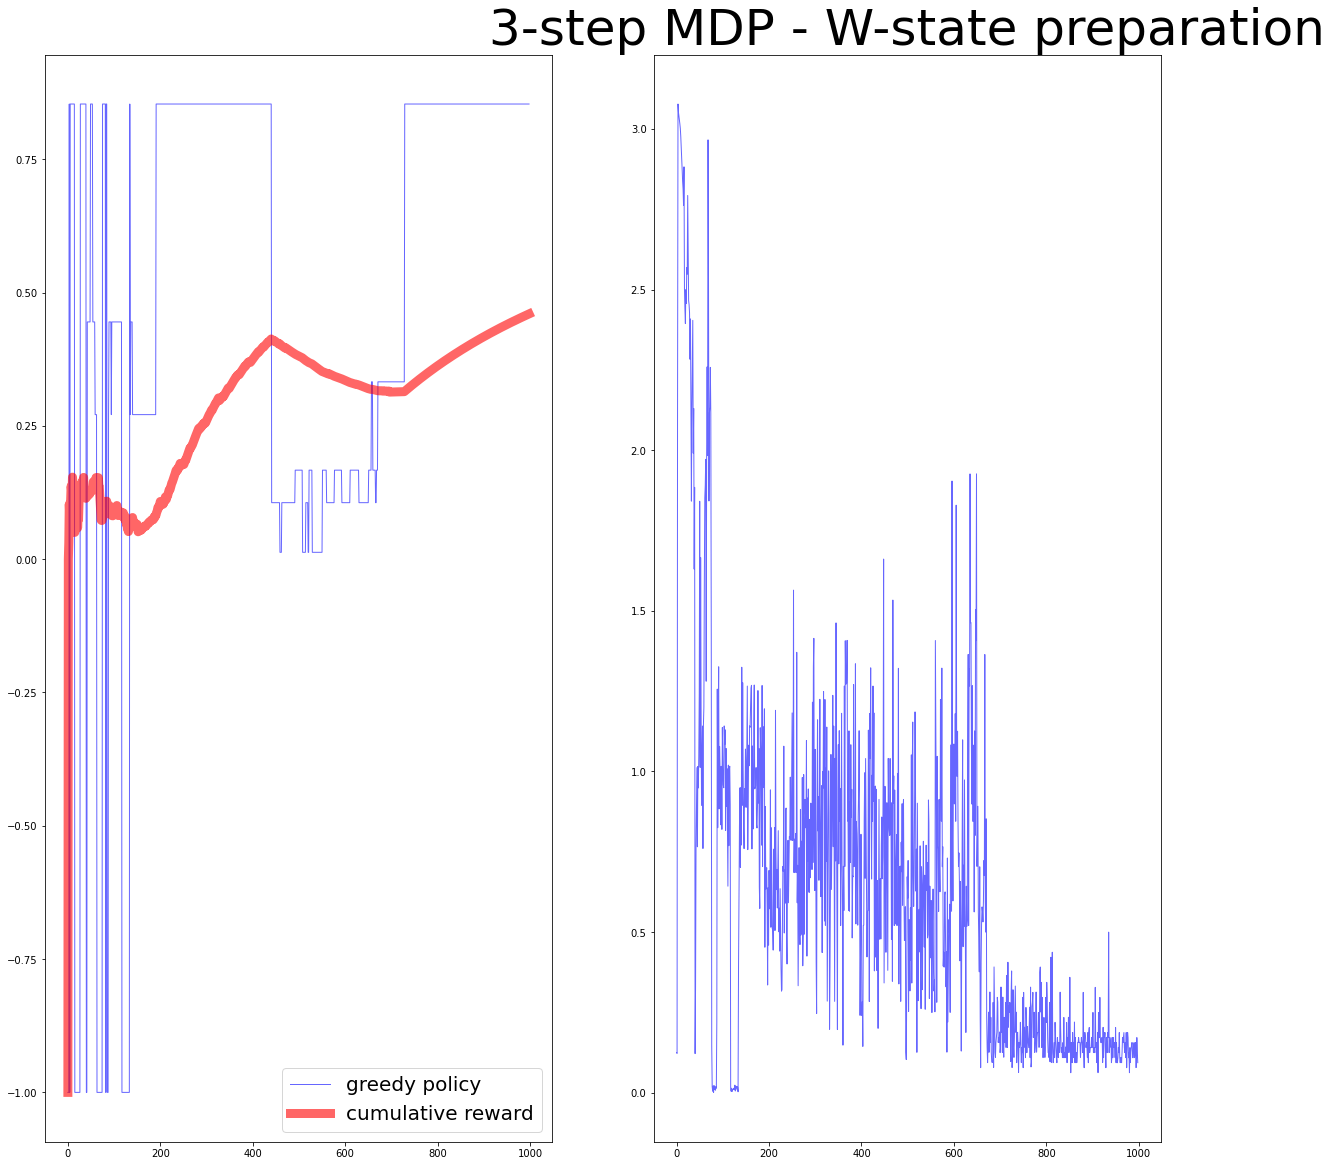

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**3,1)
tt = .8*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=32))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")

100%|██████████| 999/999 [00:49<00:00, 20.37it/s]


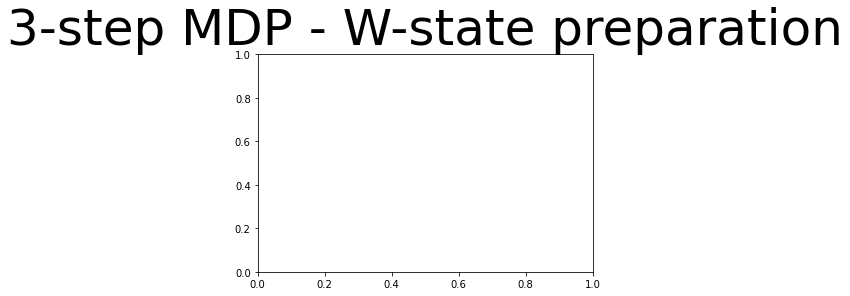

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


solver = PennylaneSolver(3, combinatorial_only=True)
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.1)

n_qubits = 3
optimizer = tf.keras.optimizers.Adam(lr=0.01)


def learning_step(critic, buffer, optimizer, batch_size=32):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = critic.give_action(next_states[inda], ep=0)
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss.numpy()
    
env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**3,1)
tt = .8*len(episodes)/np.log(1/0.01)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
    
lhist=[]
state = env.reset()
critic.give_action(state,0)#initialize
critic_target.give_action(state,0)#initialize.

for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    lhist.append(learning_step(critic, buffer, optimizer, batch_size=32))
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    
plt.title("3-step MDP - W-state preparation", size=50)
ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax1.legend(prop={"size":20})
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")
